In [1]:
!pip install boto3 netCDF4 xarray pyresample

In [2]:
import os
import datetime as dt

import boto3
from netCDF4 import Dataset
import matplotlib.pyplot as plt

from pyresample import image, bilinear
from pyresample.utils import load_cf_area

/opt/conda/lib/python3.9/site-packages/pyresample/bilinear/__init__.py:50: UserWarning: XArray and/or zarr not found, XArrayBilinearResampler won't be available.
  warnings.warn("XArray and/or zarr not found, XArrayBilinearResampler won't be available.")


In [3]:
def get_filename(s3, date, template_0, template_1):
    """ Find filename for a given date """
    filename = None
    prefix = test_date.strftime(template_0)
    req_key = test_date.strftime(template_1)
    objects = s3.list_objects(Delimiter='/', Bucket="DIAS", Prefix=prefix, MaxKeys=1000)
    if 'Contents' in objects:
        for cont in objects['Contents']:
            if req_key == cont['Key']:
                filename = cont['Key']
                return filename


In [4]:
access_key='anystring'
secret_key='anystring'

host='http://data.cloudferro.com'

# search last 5 days
tolerance = 5

# how to search data by date
templates = [
    [
        'CMEMS/NRT/ARC/PHY/ARCTIC_ANALYSISFORECAST_PHY_ICE_002_011/%Y/%m/%d/',
        '%Y%m%d_hr-nersc-MODEL-nextsimf-ARC-b%Y%m%d-fv00.0.nc'
    ],
    [
        'CMEMS/NRT/GLO/SI/SEAICE_GLO_SEAICE_L4_NRT_OBSERVATIONS_011_001/%Y/%m/%d/',
        'ice_conc_nh_polstere-100_multi_%Y%m%d1200.nc',
    ]
]

# where to save data for analysis
work_dir = '/home/jovyan/work/jupyter_demo/'

# how to read data from netcdf files
var_names = ['siconc', 'ice_conc']
factors = [1, 0.01]

In [5]:
# connect to S3
s3 = boto3.client('s3',aws_access_key_id=access_key, aws_secret_access_key=secret_key, endpoint_url=host,)

In [6]:
# find the latest remote files
test_dates = [dt.datetime.now() - dt.timedelta(i) for i in range(tolerance)]
for test_date in test_dates:
    rem_files = []
    for t0, t1 in templates:
        t1 = t0 + t1
        rem_files.append(get_filename(s3, test_date, t0, t1))
    if rem_files[0] is not None and rem_files[1] is not None:
        break

print(rem_files)

['CMEMS/NRT/ARC/PHY/ARCTIC_ANALYSISFORECAST_PHY_ICE_002_011/2021/12/14/20211214_hr-nersc-MODEL-nextsimf-ARC-b20211214-fv00.0.nc', 'CMEMS/NRT/GLO/SI/SEAICE_GLO_SEAICE_L4_NRT_OBSERVATIONS_011_001/2021/12/14/ice_conc_nh_polstere-100_multi_202112141200.nc']


In [7]:
# download the latest files
loc_files = [os.path.join(work_dir, os.path.basename(i)) for i in rem_files]

for rf, lf in zip(rem_files, loc_files):
    print(rf, lf)
    s3.download_file('DIAS', rf, lf)

CMEMS/NRT/ARC/PHY/ARCTIC_ANALYSISFORECAST_PHY_ICE_002_011/2021/12/14/20211214_hr-nersc-MODEL-nextsimf-ARC-b20211214-fv00.0.nc /home/jovyan/work/jupyter_demo/20211214_hr-nersc-MODEL-nextsimf-ARC-b20211214-fv00.0.nc
CMEMS/NRT/GLO/SI/SEAICE_GLO_SEAICE_L4_NRT_OBSERVATIONS_011_001/2021/12/14/ice_conc_nh_polstere-100_multi_202112141200.nc /home/jovyan/work/jupyter_demo/ice_conc_nh_polstere-100_multi_202112141200.nc


dict_keys(['stereographic', 'y', 'x', 'longitude', 'latitude', 'time', 'time_bnds', 'siconc', 'sithick', 'sisnthick', 'vxsi', 'vysi'])


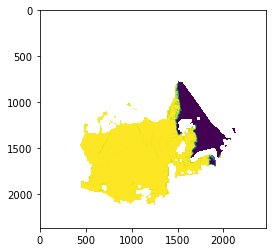

dict_keys(['Polar_Stereographic_Grid', 'time', 'time_bnds', 'xc', 'yc', 'lat', 'lon', 'ice_conc', 'ice_conc_unfiltered', 'masks', 'confidence_level', 'status_flag', 'total_uncertainty', 'smearing_uncertainty', 'algorithm_uncertainty'])


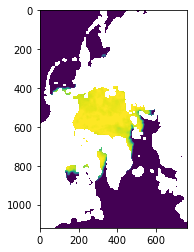

In [8]:
# plot the latest files
sic_arrays = []
for lf, var_name, factor in zip(loc_files, var_names, factors):
    nextsim_ds = Dataset(lf)
    print(nextsim_ds.variables.keys())
    sic = nextsim_ds[var_name][0] * factor

    plt.imshow(sic)
    plt.show()
    sic_arrays.append(sic)

In [9]:
# collocate
nextsim_area, _ = load_cf_area(loc_files[0])
nc_area, _ = load_cf_area(loc_files[1])
nextsim_quick = bilinear.NumpyBilinearResampler(nextsim_area, nc_area, radius_of_influence=50000)
sic_0_pro = nextsim_quick.resample(sic_arrays[0])

/opt/conda/lib/python3.9/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
/opt/conda/lib/python3.9/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
/opt/conda/lib/python3.9/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
/opt/conda/lib/p

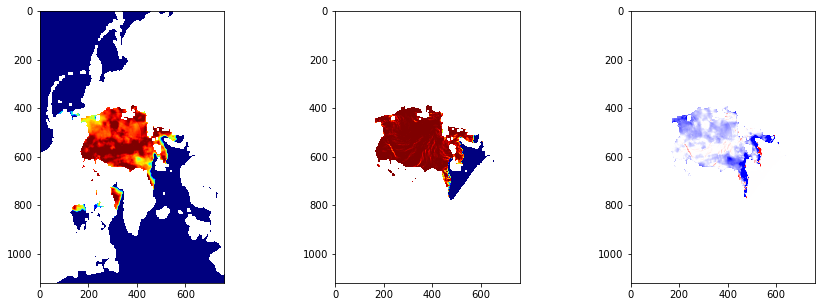

In [10]:
# find difference an plot
imgs = [sic_arrays[1], sic_0_pro, sic_arrays[1] - sic_0_pro]

clims = [[0.8, 1], [0.8, 1], [-0.1, 0.1]]
cmaps = ['jet', 'jet', 'bwr']
fig, ax = plt.subplots(1,3, figsize=(15,5))

for a, img, clim, cmap in zip(ax, imgs, clims, cmaps):
    a.imshow(img, clim=clim, cmap=cmap)
plt.show()